In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from gensim.models import Phrases
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

### Reading the previosly cleaned data

In [2]:
import preprocess_text as pt

#import our function to import data and clean it 
train_df,val_df,test_df = pt.suicidal_intent_data_load()
train_df.head()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


target                                               text
1148573       0  omg, bb i love your new picture &lt;3 it's gor...
698865        1   dammit. my moms in chicago. im home babysitting.
1176076       0  feel like bowling melons- like fruit instead o...
1024321       0                                  have fun at lunch
554154        1  oh yeah baby... sorting a music database befor...

### Remove stop words

In [3]:
stop_words = stopwords.words('english')

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
train_df['text'] = train_df['text'].apply(remove_stopwords)
test_df['text'] = test_df['text'].apply(remove_stopwords)
val_df['text'] = val_df['text'].apply(remove_stopwords)

train_df.head()

target                                               text
1101153       0                               page little miss xxx
715197        1  hopefully i'll see tomorrow then. i'll there, ...
978528        0                            goodnight! sweetdreams!
827186        0                       not. drinks ardens apartment
1440174       0  came back friends graduation party. nice seein...

### Stemming

Stemming reduces the inflectional and derivational forms of words to a common base form, which can simplify text analysis and improve the accuracy of text-based applications.

For example, the words "running", "runs", and "ran" can be reduced to their stem "run", which can help to identify them as variants of the same word and thus improve the accuracy of analysis.

In [3]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text


 
train_df['text'] = train_df['text'].apply(stemm_text)
test_df['text'] = test_df['text'].apply(stemm_text)
val_df['text'] = val_df['text'].apply(stemm_text)
train_df.head()

### WordCloud Viz

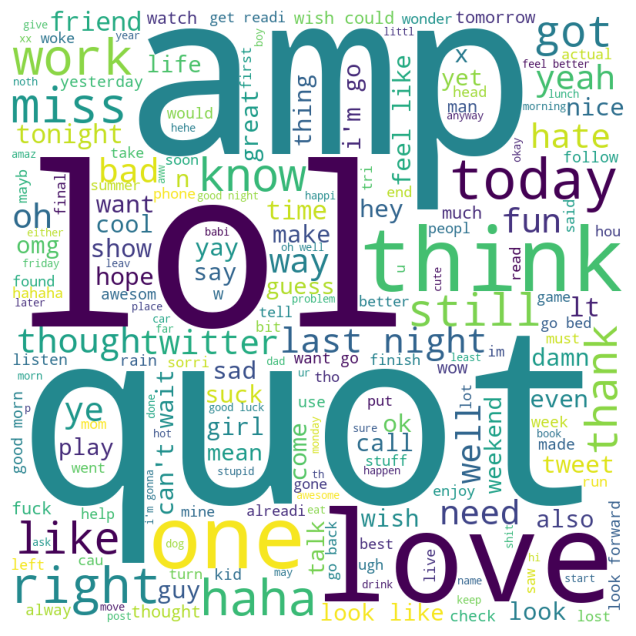

In [5]:
from wordcloud import WordCloud
stop_words = ["amp", "quot"]
# create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words,
                      width = 800, height = 800,
                      background_color = "white",
                     min_font_size = 10)

text = " ".join(i for i in train_df.text)
text = text + " ".join(i for i in val_df.text)
wordcloud = wordcloud.generate(text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:

stop_words = ["amp", "quot"]

# create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words,
                      width = 800, height = 800,
                      background_color = "white",
                     min_font_size = 10)

text1 = " ".join(i for i in train_df[train_df["target"]==1].text)
text1 = text1 + " ".join(i for i in val_df[val_df["target"]==1].text)
wordcloud = wordcloud.generate(text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Vectorization

##### CountVectorizer

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# create a CountVectorizer object
count_vec = CountVectorizer()

# fit and transform the data
x_train_cvec = count_vec.fit_transform(train_df.text)
x_test_cvec  = count_vec.fit_transform(test_df.text)
val_df_cvec  = count_vec.fit_transform(val_df.text)

##### TF-IDF Vectorizer

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(ngram_range=(1,2),max_features=3891472)
tfidf_vec.fit(train_df.text)

TfidfVectorizer(max_features=3891472, ngram_range=(1, 2))

In [8]:
x_train_tfidf = tfidf_vec.transform(train_df.text)
x_test_tfidf  = tfidf_vec.transform(test_df.text)
val_df_tfidf  = tfidf_vec.transform(val_df.text)

##### Word2Vec

In [10]:
from gensim.models import Word2Vec

# Tokenize the sentences in the train DataFrame
sentences = train_df.text.apply(lambda x: word_tokenize(x)).tolist()
# Train your Word2Vec model
train_df_word2vec = Word2Vec(sentences, min_count=1)


# Tokenize the sentences in the test DataFrame
sentences = test_df.text.apply(lambda x: word_tokenize(x)).tolist()
# Train your Word2Vec model
test_df_word2vec = Word2Vec(sentences, min_count=1)


# Tokenize the sentences in the test DataFrame
sentences = val_df.text.apply(lambda x: word_tokenize(x)).tolist()
# Train your Word2Vec model
val_df_word2vec = Word2Vec(sentences, min_count=1)

### Modeling

#### Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score, 
                             recall_score, 
                             f1_score, 
                             classification_report,
                             accuracy_score)

LogReg = LogisticRegression()

LogReg.fit(x_train_tfidf, train_df.target)
y_pred = LogReg.predict(x_test_tfidf)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
accuracy = accuracy_score(test_df.target, y_pred)
precision = precision_score(test_df.target, y_pred)
recall = recall_score(test_df.target, y_pred)
f1 = f1_score(test_df.target, y_pred)

print(f"Model: Logistic Regression on TF-IDF")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Model: Logistic Regression on TF-IDF
Accuracy: 0.82
Precision: 0.83
Recall: 0.80
F1 score: 0.82


In [14]:
LogReg2 = LogisticRegression()
LogReg2.fit(x_train_cvec, train_df.target)
y_pred = LogReg2.predict(x_test_cvec)

accuracy = accuracy_score(test_df.target, y_pred)
precision = precision_score(test_df.target, y_pred)
recall = recall_score(test_df.target, y_pred)
f1 = f1_score(test_df.target, y_pred)

print(f"Model: Logistic Regression on CountVectorizer")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: X has 260143 features, but LogisticRegression is expecting 226253 features as input.

In [15]:
LogReg3 = LogisticRegression()
LogReg3.fit(train_df_word2vec, train_df.target)
y_pred = LogReg3.predict(test_df_word2vec)

accuracy = accuracy_score(test_df.target, y_pred)
precision = precision_score(test_df.target, y_pred)
recall = recall_score(test_df.target, y_pred)
f1 = f1_score(test_df.target, y_pred)

print(f"Model: Logistic Regression on Word2Vec")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

TypeError: float() argument must be a string or a number, not 'Word2Vec'

#### Linear SVC

In [34]:
from sklearn.svm import LinearSVC

LSVC = LinearSVC()

LSVC.fit(x_train_tfidf, train_df.target)
y_pred = LSVC.predict(x_test_tfidf)

In [37]:
accuracy = accuracy_score(test_df.target, y_pred)
precision = precision_score(test_df.target, y_pred)
recall = recall_score(test_df.target, y_pred)
f1 = f1_score(test_df.target, y_pred)

print(f"Model: Linear SVC")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")
print()

Model: Linear SVC
Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1 score: 0.93



#### Decision Tree Classifier

In [ ]:
#Dont run it.. I was waiting for over 15 min.. it´s probably going to be overfitted.
#from sklearn.tree import DecisionTreeClassifier

#DTC = DecisionTreeClassifier()

#DTC.fit(x_train_tfidf, train_df.target)
#y_pred = DTC.predict(x_test_tfidf)

In [ ]:
accuracy = accuracy_score(test_df.target, y_pred)
precision = precision_score(test_df.target, y_pred)
recall = recall_score(test_df.target, y_pred)
f1 = f1_score(test_df.target, y_pred)

print(f"Model: Decision Tree Classifier")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")
print()

### Putting our model to a test

In [16]:
promp = "I had a horrible day, I want to kill myself. I dont belong in this world anymore."

# Count Vect
promp_c_vec = count_vec.transform(promp)
#TF-IDF
promp_tf_vec = tfidf_vec.transform(promp)
# Word 2 Vec 
sentences = word_tokenize(promp).tolist()
promp_w2vec = Word2Vec(sentences, min_count=1)


promp_pred = model.predict(promp_vec)
promp_pred

ValueError: Iterable over raw text documents expected, string object received.